In [1]:
%pip install zeep

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [zeep]
Note: you may need to restart the kernel to use updated packages.


In [1]:
%pip install pandas lxml

Note: you may need to restart the kernel to use updated packages.


### **XML Processing Step 1: Inspection**

In [36]:
import pandas as pd
from lxml import etree

INPUT_XML = 'serum_metabolites.xml' 

def inspect_xml_structure(xml_file_path):
    print(f"--- Inspecting structure of {xml_file_path} ---")
    
    # We only want to look at the FIRST metabolite to see its keys
    context = etree.iterparse(xml_file_path, events=('end',))
    
    for event, elem in context:
        # We wait until we hit a 'metabolite' tag
        if elem.tag.endswith('metabolite'):
            
            print(f"\nRoot Element: {elem.tag}")
            print("Children tags found inside:")
            
            # Print every immediate child tag
            found_concentrations = False
            for child in elem:
                # Clean the tag name for readability (remove the long URL part)
                clean_tag = child.tag.split('}')[-1] if '}' in child.tag else child.tag
                print(f"  - <{clean_tag}>")
                
                if clean_tag == 'concentrations':
                    found_concentrations = True
                    print("    (!!! FOUND concentrations tag here !!!)")
                    # Let's peek inside to see if it's empty
                    if len(child) == 0:
                         print("    (But it is EMPTY inside)")
                    else:
                         print(f"    (Contains {len(child)} items inside)")

                # Check for other common hiding spots
                if clean_tag == 'biological_properties':
                     print("    (Checking inside biological_properties...)")
                     for subchild in child:
                         clean_sub = subchild.tag.split('}')[-1]
                         print(f"      -- <{clean_sub}>")

            # Stop after the first one so we don't flood the screen
            break
            
    print("\n--- Inspection Complete ---")

if __name__ == "__main__":
    inspect_xml_structure(INPUT_XML)

--- Inspecting structure of serum_metabolites.xml ---

Root Element: {http://www.hmdb.ca}metabolite
Children tags found inside:
  - <version>
  - <creation_date>
  - <update_date>
  - <accession>
  - <status>
  - <secondary_accessions>
  - <name>
  - <description>
  - <synonyms>
  - <chemical_formula>
  - <average_molecular_weight>
  - <monisotopic_molecular_weight>
  - <iupac_name>
  - <traditional_iupac>
  - <cas_registry_number>
  - <smiles>
  - <inchi>
  - <inchikey>
  - <taxonomy>
  - <ontology>
  - <state>
  - <experimental_properties>
  - <predicted_properties>
  - <spectra>
  - <biological_properties>
    (Checking inside biological_properties...)
      -- <cellular_locations>
      -- <biospecimen_locations>
      -- <tissue_locations>
      -- <pathways>
  - <normal_concentrations>
  - <abnormal_concentrations>
  - <diseases>
  - <chemspider_id>
  - <drugbank_id>
  - <foodb_id>
  - <pubchem_compound_id>
  - <pdb_id>
  - <chebi_id>
  - <phenol_explorer_compound_id>
  - <knapsa

### **XML Processing Step 2: XML -> CSV Converter**

In [1]:
import pandas as pd
from lxml import etree
import os

def convert_hmdb_split_xml(xml_file_path, output_csv_path):
    
    print(f"--- Processing {xml_file_path} ---")
    
    # 1. Define Namespace (We confirmed this from your X-Ray)
    ns = {'hmdb': 'http://www.hmdb.ca'}

    rows = []
    
    # Counters
    count_metabolites = 0
    count_normal_records = 0
    count_abnormal_records = 0
    
    # 2. Parse the file
    context = etree.iterparse(
        xml_file_path, 
        events=('end',), 
        tag='{http://www.hmdb.ca}metabolite'
    )

    for event, elem in context:
        
        # --- Helpers ---
        def get_text(element, tag):
            node = element.find(f'hmdb:{tag}', ns)
            return node.text if node is not None else None

        # Basic Info
        m_name = get_text(elem, 'name')
        m_id = get_text(elem, 'accession')

        # --- BRANCH A: Normal Concentrations ---
        normals = elem.find('hmdb:normal_concentrations', ns)
        if normals is not None:
            for conc in normals.findall('hmdb:concentration', ns):
                rows.append({
                    'hmdb_id': m_id,
                    'metabolite_name': m_name,
                    'type': 'Normal', # Explicitly labeling the source
                    'biospecimen': get_text(conc, 'biospecimen'),
                    'concentration_value': get_text(conc, 'concentration_value'),
                    'concentration_units': get_text(conc, 'concentration_units'),
                    'subject_age': get_text(conc, 'subject_age'),
                    'subject_sex': get_text(conc, 'subject_sex'),
                    'subject_condition': 'Normal', # Default for this branch
                })
                count_normal_records += 1

        # --- BRANCH B: Abnormal Concentrations ---
        abnormals = elem.find('hmdb:abnormal_concentrations', ns)
        if abnormals is not None:
            for conc in abnormals.findall('hmdb:concentration', ns):
                # In abnormal sections, we look for the specific disease/condition
                # Sometimes it is tagged as 'disease', sometimes 'patient_information'
                condition = get_text(conc, 'disease')
                if not condition:
                     condition = get_text(conc, 'condition') 

                rows.append({
                    'hmdb_id': m_id,
                    'metabolite_name': m_name,
                    'type': 'Abnormal',
                    'biospecimen': get_text(conc, 'biospecimen'),
                    'concentration_value': get_text(conc, 'concentration_value'),
                    'concentration_units': get_text(conc, 'concentration_units'),
                    'subject_age': get_text(conc, 'subject_age'),
                    'subject_sex': get_text(conc, 'subject_sex'),
                    'subject_condition': condition, # Specific disease
                })
                count_abnormal_records += 1

        # Memory Cleanup
        elem.clear()
        while elem.getprevious() is not None:
            del elem.getparent()[0]
            
        count_metabolites += 1
        if count_metabolites % 100 == 0:
            print(f"Scanned {count_metabolites} metabolites. Found {count_normal_records} normal, {count_abnormal_records} abnormal.", end='\r')

    print(f"\n\nFinished.")
    print(f"Total Metabolites: {count_metabolites}")
    print(f"Total Concentration Records: {len(rows)}")

    if len(rows) == 0:
        print("❌ Still 0 records. The XML tags inside normal/abnormal might be named differently than 'concentration'.")
        return

    # 3. Save to CSV
    df = pd.DataFrame(rows)
    
    # Create a numeric column for analysis (forcing errors to NaN)
    df['concentration_numeric'] = pd.to_numeric(df['concentration_value'], errors='coerce')
    
    df.to_csv(output_csv_path, index=False)
    print(f"✅ Data saved to {output_csv_path}")

# --- EXECUTION ---
INPUT_XML = 'serum_metabolites.xml' 
OUTPUT_CSV = 'hmdb_serum_final.csv'

if __name__ == "__main__":
    if os.path.exists(INPUT_XML):
        convert_hmdb_split_xml(INPUT_XML, OUTPUT_CSV)
    else:
        print(f"Error: {INPUT_XML} not found.")

--- Processing serum_metabolites.xml ---
Scanned 40600 metabolites. Found 47821 normal, 34400 abnormal.

Finished.
Total Metabolites: 40678
Total Concentration Records: 82299
✅ Data saved to hmdb_serum_final.csv


### **XML Processing Step 3: Targeted Metabolite Seeker**

In [2]:
import pandas as pd
import numpy as np
import sys
import os

# --- Configuration ---
STUDY_FILE = 'metabolite_data.csv'
INPUT_HMDB_FILE = 'hmdb_serum_final.csv'
# New output file name containing all initial matches
OUTPUT_HMDB_FILE = 'hmdb_metabolite_only_filtered.csv' 
STUDY_UP_METABOLITES_COL = 'Up-regulated metabolites'
STUDY_DOWN_METABOLITES_COL = 'Down-regulated metabolites'


def get_target_metabolites(file_path):
    """
    Reads the study file and returns a set of all unique up/downregulated metabolite names.
    """
    try:
        df = pd.read_csv(file_path, header=0) 
        target_metabolites = set()
        
        # We process both the Up-regulated and Down-regulated columns
        for col in [STUDY_UP_METABOLITES_COL, STUDY_DOWN_METABOLITES_COL]:
            for cell_content in df[col].dropna().astype(str):
                # Split and clean metabolite names (handles "Metabolite A, Metabolite B")
                metabolites = [m.strip() for m in cell_content.split(',') if m.strip()]
                target_metabolites.update(metabolites)
        
        return target_metabolites
    except FileNotFoundError:
        print(f"🛑 Error: Study file '{file_path}' not found.")
        sys.exit()
    except Exception as e:
        print(f"🛑 Error reading study file: {e}")
        sys.exit()
        
def standardize_metabolite_name(name):
    """
    Applies simple normalization (case-insensitivity) for lookup consistency.
    """
    if not isinstance(name, str):
        return name
    return name.lower().strip()

# 1. Get All Target Metabolites from Study File
target_names = get_target_metabolites(STUDY_FILE)
if not target_names:
    print("No metabolites found in the study file columns. Cannot proceed.")
    sys.exit()

print(f"=====================================================")
print(f"  Data Preparation: Filtering {len(target_names)} Target Metabolites")
print(f"=====================================================")

# 2. Load HMDB Concentration Data
try:
    hmdb_df = pd.read_csv(INPUT_HMDB_FILE)
except FileNotFoundError:
    print(f"🛑 Error: HMDB Concentration file '{INPUT_HMDB_FILE}' not found. Cannot proceed.")
    sys.exit()

# Ensure 'concentration_numeric' is a proper float column for kinetic analysis readiness
hmdb_df['concentration_numeric'] = pd.to_numeric(hmdb_df['concentration_numeric'], errors='coerce')

# 3. Apply Name Filtering
hmdb_df['Standardized_Name'] = hmdb_df['metabolite_name'].apply(standardize_metabolite_name)
target_standardized_names = {standardize_metabolite_name(name) for name in target_names}

# Filter: Keep only rows where the standardized metabolite name matches a target name
final_filtered_df = hmdb_df[
    hmdb_df['Standardized_Name'].isin(target_standardized_names) &
    # We still drop rows where the numeric concentration value could not be parsed
    (hmdb_df['concentration_numeric'].notna()) 
].copy()

initial_rows = len(final_filtered_df)

print(f"Total target metabolites found: {len(target_standardized_names)}")
print(f"Number of individual data points kept (Metabolite Match Only): {initial_rows}")


# 4. Save the Cleaned Data File
# Drop the temporary standardized name column before saving
final_filtered_df = final_filtered_df.drop(columns=['Standardized_Name'])

final_filtered_df.to_csv(OUTPUT_HMDB_FILE, index=False)

print("\n=====================================================")
print(f"✅ Data preparation complete. The filtered dataset is saved to: '{OUTPUT_HMDB_FILE}'")
print("This file contains all available HMDB data points for your target metabolites.")

  Data Preparation: Filtering 118 Target Metabolites
Total target metabolites found: 109
Number of individual data points kept (Metabolite Match Only): 228

✅ Data preparation complete. The filtered dataset is saved to: 'hmdb_metabolite_only_filtered.csv'
This file contains all available HMDB data points for your target metabolites.


### **Standardized Extractor**

In [3]:
import pandas as pd
from lxml import etree
import os

def convert_hmdb_standardized(xml_file_path, output_csv_path):
    print(f"--- Processing {xml_file_path} ---")
    
    ns = {'hmdb': 'http://www.hmdb.ca'}
    rows = []
    
    context = etree.iterparse(xml_file_path, events=('end',), tag='{http://www.hmdb.ca}metabolite')

    for event, elem in context:
        
        # 1. Get Metabolite Info
        def get_text(e, tag):
            n = e.find(f'hmdb:{tag}', ns)
            return n.text if n is not None else None
            
        m_name = get_text(elem, 'name')
        m_id = get_text(elem, 'accession')
        
        # 2. Helper to process concentration lists
        def extract_concentrations(conc_list, source_type):
            for conc in conc_list:
                
                # --- CONSOLIDATION LOGIC ---
                # HMDB mixes 'subject' and 'patient' tags. We check both.
                
                # SEX
                sex = get_text(conc, 'subject_sex')
                if not sex: sex = get_text(conc, 'patient_sex')
                
                # AGE
                age = get_text(conc, 'subject_age')
                if not age: age = get_text(conc, 'patient_age')
                
                # CONDITION (Normal usually has 'subject_condition', Disease has 'patient_information' or 'disease')
                condition = get_text(conc, 'subject_condition')
                if not condition: condition = get_text(conc, 'patient_information')
                if not condition: condition = get_text(conc, 'disease')
                
                # REFERENCES
                # References are often nested. We try to grab the text or PubMed ID.
                ref_text = ""
                refs = conc.find('hmdb:references', ns)
                if refs is not None:
                    # Grab all text inside the reference tag
                    ref_text = "".join(refs.itertext()).strip()

                rows.append({
                    'hmdb_id': m_id,
                    'metabolite_name': m_name,
                    'data_source': source_type,
                    'biospecimen': get_text(conc, 'biospecimen'),
                    'concentration_value': get_text(conc, 'concentration_value'),
                    'concentration_units': get_text(conc, 'concentration_units'),
                    'subject_sex': sex,           # Consolidated Column
                    'subject_age': age,           # Consolidated Column
                    'subject_condition': condition, # Consolidated Column
                    'reference': ref_text
                })

        # 3. Process Both Branches
        normals = elem.find('hmdb:normal_concentrations', ns)
        if normals is not None:
            extract_concentrations(normals.findall('hmdb:concentration', ns), 'Normal')

        abnormals = elem.find('hmdb:abnormal_concentrations', ns)
        if abnormals is not None:
            extract_concentrations(abnormals.findall('hmdb:concentration', ns), 'Abnormal')

        # Cleanup
        elem.clear()
        while elem.getprevious() is not None:
            del elem.getparent()[0]

    # 4. Save to CSV
    df = pd.DataFrame(rows)
    df.to_csv(output_csv_path, index=False)
    print(f"✅ Extraction Complete. Saved to {output_csv_path}")

# --- EXECUTION ---
INPUT_XML = 'serum_metabolites.xml'
OUTPUT_CSV = 'hmdb_standardized.csv'

if __name__ == "__main__":
    if os.path.exists(INPUT_XML):
        convert_hmdb_standardized(INPUT_XML, OUTPUT_CSV)

--- Processing serum_metabolites.xml ---
✅ Extraction Complete. Saved to hmdb_standardized.csv


### **LAUNCH PAD**

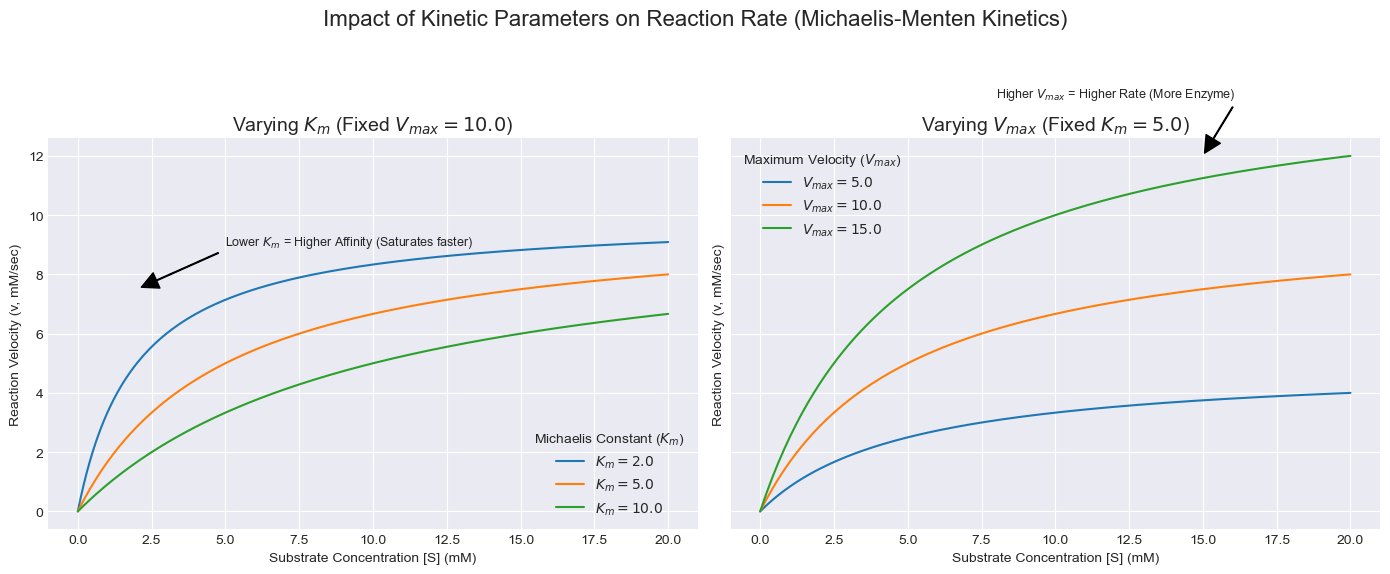


Simulation complete. A plot showing the effects of K_m and V_max variation has been generated.
Baseline Parameters: V_max=10.0 mM/sec, K_m=5.0 mM


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. The Core Michaelis-Menten Equation ---

def michaelis_menten(S, V_max, K_m):
    """
    Calculates the reaction velocity (v) based on the Michaelis-Menten equation.
    
    v = (V_max * [S]) / (K_m + [S])
    
    Args:
        S (array or float): Substrate concentration [S].
        V_max (float): Maximum reaction velocity.
        K_m (float): Michaelis constant (substrate conc. at 1/2 V_max).
        
    Returns:
        array or float: Reaction velocity (v).
    """
    # Ensure K_m + S is not zero to prevent division by zero errors
    denominator = K_m + S
    if np.any(denominator == 0):
        # Handle the edge case, though substrate concentration is usually > 0
        denominator[denominator == 0] = 1e-9 
        
    return (V_max * S) / denominator

# --- 2. Simulation Setup ---

# Define a range of substrate concentrations [S] for the x-axis
# We simulate from 0 to 20 units of concentration.
S_range = np.linspace(0, 20, 200)

# Define baseline kinetic parameters
V_max_base = 10.0  # (e.g., in mM/sec)
K_m_base = 5.0     # (e.g., in mM)

# --- 3. Varying K_m (Substrate Affinity) ---

# Define different K_m values to simulate varying affinity
K_m_variants = [2.0, 5.0, 10.0] 
# A lower K_m means higher affinity (saturation achieved faster)
# A higher K_m means lower affinity (more substrate needed for saturation)

# Calculate velocities for each K_m variant
velocities_K_m = {
    km: michaelis_menten(S_range, V_max_base, km) 
    for km in K_m_variants
}

# --- 4. Varying V_max (Enzyme Concentration/Catalytic Power) ---

# Define different V_max values to simulate varying enzyme abundance
V_max_variants = [5.0, 10.0, 15.0] 
# V_max is directly proportional to enzyme concentration

# Calculate velocities for each V_max variant
velocities_V_max = {
    vmax: michaelis_menten(S_range, vmax, K_m_base) 
    for vmax in V_max_variants
}

# --- 5. Visualization ---

# Set up the plot layout
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
fig.suptitle('Impact of Kinetic Parameters on Reaction Rate (Michaelis-Menten Kinetics)', fontsize=16)

# --- Plot 1: Varying K_m ---
ax1 = axes[0]
for km, v in velocities_K_m.items():
    ax1.plot(S_range, v, label=f'$K_m = {km:.1f}$')
    
ax1.set_title(f'Varying $K_m$ (Fixed $V_{{max}}={V_max_base:.1f}$)', fontsize=14)
ax1.set_xlabel('Substrate Concentration [S] (mM)')
ax1.set_ylabel('Reaction Velocity (v, mM/sec)')
ax1.legend(title='Michaelis Constant ($K_m$)')
ax1.annotate(
    'Lower $K_m$ = Higher Affinity (Saturates faster)', 
    xy=(2, 7.5), xytext=(5, 9), arrowprops=dict(facecolor='black', shrink=0.05, width=0.5), 
    fontsize=9
)


# --- Plot 2: Varying V_max ---
ax2 = axes[1]
for vmax, v in velocities_V_max.items():
    ax2.plot(S_range, v, label=f'$V_{{max}} = {vmax:.1f}$')

ax2.set_title(f'Varying $V_{{max}}$ (Fixed $K_m={K_m_base:.1f}$)', fontsize=14)
ax2.set_xlabel('Substrate Concentration [S] (mM)')
ax2.set_ylabel('Reaction Velocity (v, mM/sec)')
ax2.legend(title='Maximum Velocity ($V_{max}$)')
ax2.annotate(
    'Higher $V_{max}$ = Higher Rate (More Enzyme)', 
    xy=(15, 12), xytext=(8, 14), arrowprops=dict(facecolor='black', shrink=0.05, width=0.5), 
    fontsize=9
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

print("\nSimulation complete. A plot showing the effects of K_m and V_max variation has been generated.")
print(f"Baseline Parameters: V_max={V_max_base} mM/sec, K_m={K_m_base} mM")

In [4]:
import pandas as pd
import sys

# --- CONFIGURATION (ADJUSTED FOR YOUR CSV) ---
INPUT_FILE_NAME = 'metabolite_data.csv'

# Column names identified from your CSV header:
SAMPLE_TYPE_COL = 'Specimens'
UP_METABOLITES_COL = 'Up-regulated metabolites'
DOWN_METABOLITES_COL = 'Down-regulated metabolites'

# Target values for filtering:
TARGET_SAMPLE_TYPES = ['Serum', 'Blood', 'Plasma'] # Added 'Plasma' as it appears in the snippet
# ---------------------------------------------------

def filter_and_categorize_data(file_path):
    """
    Loads a CSV, filters it for specific specimen types, and parses the 
    comma-separated metabolite lists into unique categories.
    """
    try:
        # 1. Load the CSV file
        print(f"Loading data from {file_path}...")
        # Use header=0 assuming the column names are in the first row
        df = pd.read_csv(file_path, header=0) 
        print(f"Original data shape: {df.shape}")

        # Check if essential columns exist
        required_cols = [SAMPLE_TYPE_COL, UP_METABOLITES_COL, DOWN_METABOLITES_COL]
        if not all(col in df.columns for col in required_cols):
            print("\n❌ Error: Column configuration mismatch.")
            print("Please ensure the CONFIGURATION variables at the top of the script match your CSV headers.")
            print(f"Missing one or more required columns: {required_cols}")
            return
        
        # --- 2. Filtering by Specimen Type ---
        
        # Filter: Keep only Serum, Blood, or Plasma sample types
        sample_filter = df[SAMPLE_TYPE_COL].isin(TARGET_SAMPLE_TYPES)
        filtered_df = df[sample_filter].copy()
        
        print(f"\nFiltered data shape (Target Specimens only): {filtered_df.shape}")
        
        if filtered_df.empty:
            print(f"⚠️ Warning: Filtering resulted in an empty dataset. Check if your specimen names match: {TARGET_SAMPLE_TYPES}")
            return

        # --- 3. Parsing and Categorization ---
        
        upregulated_metabolites = set()
        downregulated_metabolites = set()
        
        # Process Upregulated Metabolites Column
        for cell_content in filtered_df[UP_METABOLITES_COL].dropna():
            # Splits the string by comma, handles multiple spaces, and strips whitespace
            metabolites = [m.strip() for m in cell_content.split(',') if m.strip()]
            upregulated_metabolites.update(metabolites)
            
        # Process Downregulated Metabolites Column
        for cell_content in filtered_df[DOWN_METABOLITES_COL].dropna():
            # Splits the string by comma, handles multiple spaces, and strips whitespace
            metabolites = [m.strip() for m in cell_content.split(',') if m.strip()]
            downregulated_metabolites.update(metabolites)


        # Convert sets to sorted lists for clean output
        up_list = sorted(list(upregulated_metabolites))
        down_list = sorted(list(downregulated_metabolites))
        
        # --- 4. Output Results ---
        
        print("\n=======================================================")
        print("                 Filtering Results")
        print("=======================================================")

        print(f"Total Unique Upregulated Metabolites: {len(up_list)}")
        print(f"Total Unique Downregulated Metabolites: {len(down_list)}")
        
        print("\n--- Upregulated Metabolites ---")
        if up_list:
            for i, metabolite in enumerate(up_list, 1):
                print(f"{i}. {metabolite}")
        else:
            print("[No Upregulated metabolites found matching criteria]")

        print("\n--- Downregulated Metabolites ---")
        if down_list:
            for i, metabolite in enumerate(down_list, 1):
                print(f"{i}. {metabolite}")
        else:
            print("[No Downregulated metabolites found matching criteria]")
        
        print("=======================================================")
        
    except FileNotFoundError:
        print(f"❌ Error: The file '{file_path}' was not found. Please ensure it is in the same directory as the script.")
    except Exception as e:
        print(f"❌ An unexpected error occurred: {e}")

if __name__ == '__main__':
    # We use the accessible file name provided by the system
    filter_and_categorize_data(INPUT_FILE_NAME)

Loading data from metabolite_data.csv...
Original data shape: (24, 8)

Filtered data shape (Target Specimens only): (22, 8)

                 Filtering Results
Total Unique Upregulated Metabolites: 64
Total Unique Downregulated Metabolites: 54

--- Upregulated Metabolites ---
1. -
2. 1
3. 12-hydroxyeicosatetraenoic acid
4. 16α-hydroxydehydroepiandrosterone 3-sulfate
5. 2-diacyl-3-β-D-galactosyl-sn-glycerol
6. 2-hydroxybutyric acid
7. 5-hydroxyhexanoic acid
8. Ascorbate
9. Choline
10. Creatine
11. Glutamate
12. Glutamic acid
13. Glycine
14. Glycodeoxycholate
15. Leucine
16. Methionine
17. N-acetylglycoproteins
18. Oleic acid
19. Phe-Phe
20. Sphingosine-1-phosphate
21. Taurocholic acid
22. Taurodeoxy cholic acid
23. Tyrosine
24. acetate
25. and N-acetylglycoproteins
26. arachidonic acid
27. arginine
28. aspartate
29. bilirubin
30. cholesterol
31. citrate
32. citrulline
33. cystathionine
34. deoxycholate 3-sulfate
35. galactose
36. glucose
37. glycerol
38. glycine
39. glycochenodeoxycholi

In [6]:
import pandas as pd
import requests
import time
import sys
import hashlib
from collections import defaultdict

# NOTE: You must install the zeep library: pip install zeep
from zeep import Client, Settings
from zeep.exceptions import Fault
from zeep.exceptions import TransportError # For catching network issues during WSDL fetching

# --- 1. CONFIGURATION (!!! ACTION REQUIRED !!!) ---
STUDY_FILE = 'metabolite_data.csv'

# BRENDA Credentials (REPLACE THESE WITH YOUR ACTUAL ACCOUNT DETAILS)
BRENDA_EMAIL = "jace.palmer@tufts.edu"
BRENDA_PASSWORD = "AtlasxAthena003$" # <<< Your plain text password goes here

# FIX: Correct WSDL URL identified from your snippet
BRENDA_WSDL = "https://www.brenda-enzymes.org/soap/brenda_zeep.wsdl"

# Study File (metabolite_data.csv) Columns
STUDY_SAMPLE_TYPE_COL = 'Specimens'
STUDY_UP_METABOLITES_COL = 'Up-regulated metabolites'
STUDY_DOWN_METABOLITES_COL = 'Down-regulated metabolites'
STUDY_TARGET_SAMPLE_TYPES = ['Serum', 'Blood', 'Plasma']

# KEGG API URL
KEGG_API_BASE = "https://rest.kegg.jp"
# ---------------------------------------------------


# --- 2. Generic API Helpers ---

def call_api_with_retry(url, max_retries=3):
    """Robust function for calling external REST APIs (KEGG)."""
    for attempt in range(max_retries):
        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()
            return response.text
        except requests.exceptions.RequestException as e:
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)
            else:
                return None
    return None

# --- 3. BRENDA Client Class ---

class BrendaClient:
    """Handles the SOAP connection and queries to the BRENDA database."""
    def __init__(self, wsdl_url, email, password):
        # Hash the password using SHA-256, as required by BRENDA
        self.password_hash = hashlib.sha256(password.encode("utf-8")).hexdigest()
        self.email = email
        
        # Zeep settings to handle large XML responses
        settings = Settings(strict=False, xml_huge_tree=True)
        
        # Initialize client, which fetches the WSDL
        self.client = Client(wsdl_url, settings=settings)
        print("✅ BRENDA SOAP Client Initialized with hashed password.")


    def get_kinetic_data(self, ec_number, parameter='Km', organism='Homo sapiens'):
        """
        Calls the BRENDA API for kinetic data using the required parameterized string format.
        """
        
        # 1. Define the specific SOAP method name
        method_name = f"get{parameter}Value"
        
        # 2. Construct the parameters list in BRENDA's required format (key*value)
        # Note the wildcards (*) are essential for flexible searching
        parameters = (
            self.email,
            self.password_hash,
            f"ecNumber*{ec_number}",
            f"organism*{organism}",
            f"{parameter.lower()}Value*", # e.g., kmValue*
            f"{parameter.lower()}ValueMaximum*", # e.g., kmValueMaximum*
            "substrate*",
            "commentary*",
            "ligandStructureId*",
            "literature*"
        )
        
        try:
            # Dynamically select the correct SOAP method from the client
            brenda_method = getattr(self.client.service, method_name)
            
            # Pass parameters using the * operator as required by the SOAP client
            result = brenda_method(*parameters)
            
            return result

        except Fault as e:
            print(f"  ❌ BRENDA SOAP Fault for EC {ec_number}: {e.message}")
            return []
        except Exception as e:
            print(f"  ❌ An unexpected error occurred during the BRENDA call: {e}")
            return []


# --- 4. Metabolite and KEGG Integration (Reused) ---

def get_target_metabolites(file_path):
    """
    Filters the study file and returns a set of all unique up/downregulated metabolites.
    """
    try:
        df = pd.read_csv(file_path, header=0) 
        sample_filter = df[STUDY_SAMPLE_TYPE_COL].isin(STUDY_TARGET_SAMPLE_TYPES)
        filtered_df = df[sample_filter].copy()
        target_metabolites = set()
        
        for col in [STUDY_UP_METABOLITES_COL, STUDY_DOWN_METABOLITES_COL]:
            for cell_content in filtered_df[col].dropna():
                metabolites = [m.strip() for m in cell_content.split(',') if m.strip()]
                target_metabolites.update(metabolites)
        
        return target_metabolites

    except Exception:
        return set()

def get_kegg_ec_data(metabolite_name):
    """Finds KEGG Compound ID and associated EC Numbers using KEGG API."""
    data = {'kegg_id': None, 'ec_numbers': set()}
    find_url = f"{KEGG_API_BASE}/find/compound/{metabolite_name.replace(' ', '+')}"
    kegg_response = call_api_with_retry(find_url)

    if kegg_response:
        first_line = kegg_response.split('\n')[0].strip()
        if first_line:
            kegg_id = first_line.split('\t')[0]
            data['kegg_id'] = kegg_id
            
            get_url = f"{KEGG_API_BASE}/get/{kegg_id}"
            get_response = call_api_with_retry(get_url)
            
            if get_response:
                for line in get_response.split('\n'):
                    if line.startswith('ENZYME'):
                        ec_candidates = line.split()
                        if len(ec_candidates) > 1:
                            data['ec_numbers'].update([ec.strip() for ec in ec_candidates[1:]])
                            
    return data

# --- 5. Main Execution and Orchestration ---

def main():
    print("==================================================================")
    print("  Metabolite-to-Kinetics Pipeline (KEGG + BRENDA SOAP Client)")
    print("==================================================================")
    
    # 1. Get Target Metabolites
    target_metabolites = get_target_metabolites(STUDY_FILE)
    if not target_metabolites:
        print("\nPipeline failed at Step 1: No valid metabolites identified. Check your CSV and configuration.")
        return

    # 2. Initialize BRENDA Client
    try:
        if BRENDA_EMAIL == "your.email@example.com":
            print("\n🛑 ERROR: Please update BRENDA_EMAIL and BRENDA_PASSWORD in the CONFIGURATION section.")
            return

        print(f"Attempting to connect to WSDL: {BRENDA_WSDL}")
        brenda_api = BrendaClient(BRENDA_WSDL, BRENDA_EMAIL, BRENDA_PASSWORD)
    except TransportError as e:
        print(f"\n🛑 FATAL ERROR: WSDL not found or network error. Error: {e}")
        return
    except Exception as e:
        print(f"\n🛑 FATAL ERROR: Could not initialize BRENDA client. Error: {e}")
        return

    # 3. Lookup KEGG EC Numbers
    metabolite_map = {}
    all_ec_numbers = set()
    
    print(f"\n--- Starting KEGG/EC Lookup for {len(target_metabolites)} Metabolites ---")
    
    # Visualizing the flow of information from raw data to kinetic parameters
    
    
    for metabolite in target_metabolites:
        kegg_data = get_kegg_ec_data(metabolite)
        ec_list = sorted(list(kegg_data['ec_numbers']))
        metabolite_map[metabolite] = {'ec': ec_list, 'kegg_id': kegg_data['kegg_id']}
        all_ec_numbers.update(ec_list)
        
    print(f"\nSummary: Identified {len(all_ec_numbers)} unique EC numbers.")
    
    # 4. Query BRENDA for Kinetic Data
    print(f"\n--- Querying BRENDA for Km Values for Enzymes in Homo sapiens ---")
    final_output = []
    queried_ecs = set() 
    
    for metabolite, data in metabolite_map.items():
        for ec in data['ec']:
            # Skip ECs already queried to avoid redundant SOAP calls and rate limits
            if ec in queried_ecs:
                continue
            
            print(f"  -> Retrieving Km for EC {ec} (Organism: Homo sapiens)...")
            km_results = brenda_api.get_kinetic_data(ec, parameter='Km', organism='Homo sapiens') 
            queried_ecs.add(ec)

            if km_results:
                for entry in km_results:
                    final_output.append({
                        'EC_Number': ec,
                        'Substrate': getattr(entry, 'substrate', 'N/A'),
                        'Organism': getattr(entry, 'organism', 'N/A'),
                        'Km_Value': getattr(entry, 'kmValue', 'N/A'),
                        'Km_Unit': getattr(entry, 'kmUnit', 'N/A'),
                        # Track the metabolite from your study that led to this EC
                        'Metabolites_Linking_To_EC': metabolite 
                    })
            else:
                 print(f"    -> No Km data found for EC {ec} in Homo sapiens.")

    # --- 6. Final Report ---
    print("\n==================================================================")
    print("                 Final BRENDA Kinetic Data Report")
    print("==================================================================")

    if final_output:
        results_df = pd.DataFrame(final_output)
        # Displaying only the most relevant columns for Km modeling
        display_cols = ['EC_Number', 'Substrate', 'Km_Value', 'Km_Unit', 'Organism', 'Metabolites_Linking_To_EC']
        print(results_df[display_cols].to_markdown(index=False))
        
        print(f"\nTotal kinetic entries found: {len(final_output)}")
    else:
        print("No kinetic data retrieved from BRENDA. Check your WSDL, credentials, and EC numbers.")
        
    print("==================================================================")

if __name__ == '__main__':
    main()

  Metabolite-to-Kinetics Pipeline (KEGG + BRENDA SOAP Client)
Attempting to connect to WSDL: https://www.brenda-enzymes.org/soap/brenda_zeep.wsdl
✅ BRENDA SOAP Client Initialized with hashed password.

--- Starting KEGG/EC Lookup for 109 Metabolites ---

Summary: Identified 204 unique EC numbers.

--- Querying BRENDA for Km Values for Enzymes in Homo sapiens ---
  -> Retrieving Km for EC 1.1.1.306 (Organism: Homo sapiens)...
    -> No Km data found for EC 1.1.1.306 in Homo sapiens.
  -> Retrieving Km for EC 1.1.98.6 (Organism: Homo sapiens)...
    -> No Km data found for EC 1.1.98.6 in Homo sapiens.
  -> Retrieving Km for EC 1.2.1.46 (Organism: Homo sapiens)...
  -> Retrieving Km for EC 1.2.2.1 (Organism: Homo sapiens)...
    -> No Km data found for EC 1.2.2.1 in Homo sapiens.
  -> Retrieving Km for EC 1.13.11.12 (Organism: Homo sapiens)...
  -> Retrieving Km for EC 1.13.11.33 (Organism: Homo sapiens)...
  -> Retrieving Km for EC 1.13.11.45 (Organism: Homo sapiens)...
    -> No Km data

In [23]:
import pandas as pd
import requests
import time
import sys
import hashlib
import json
from lxml import etree 
from collections import defaultdict

# NOTE: You must install the zeep library: pip install zeep
from zeep import Client, Settings
from zeep.exceptions import Fault
from zeep.exceptions import TransportError 

# --- 1. CONFIGURATION ---
STUDY_FILE = 'metabolite_data.csv'

# BRENDA Credentials (REPLACE THESE WITH YOUR ACTUAL ACCOUNT DETAILS)
BRENDA_EMAIL = "jace.palmer@tufts.edu" # Placeholder, replace with actual email
BRENDA_PASSWORD = "AtlasxAthena003$" # Placeholder, replace with actual password
BRENDA_WSDL = "https://www.brenda-enzymes.org/soap/brenda_zeep.wsdl"

# Output file path for the consolidated kinetic parameters
OUTPUT_FILE = 'raw_kinetic_parameters_km_kcat_brenda.csv'

# Study File (metabolite_data.csv) Columns
STUDY_SAMPLE_TYPE_COL = 'Specimens'
STUDY_UP_METABOLITES_COL = 'Up-regulated metabolites'
STUDY_DOWN_METABOLITES_COL = 'Down-regulated metabolites'
STUDY_TARGET_SAMPLE_TYPES = ['Serum', 'Blood', 'Plasma']

# KEGG API URL
KEGG_API_BASE = "https://rest.kegg.jp"

# Mapping for BRENDA API calls
BRENDA_PARAM_MAP = {
    'Km': {'method_name': 'getKmValue', 'value_field': 'kmValue', 'unit_field': 'kmUnit'},
    'Kcat': {'method_name': 'getTurnoverNumber', 'value_field': 'turnoverNumber', 'unit_field': 'turnoverNumberUnit'}
}
# ---------------------------------------------------


# --- 2. Generic API Helpers ---

def call_api_with_retry(url, max_retries=3):
    """Robust function for calling external REST APIs (KEGG)."""
    for attempt in range(max_retries):
        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()
            return response.text
        except requests.exceptions.RequestException as e:
            if attempt < max_retries - 1:
                print(f"  Warning: API call failed (attempt {attempt+1}/{max_retries}). Retrying in {2 ** attempt}s...")
                time.sleep(2 ** attempt)
            else:
                print(f"  Error: API call failed after {max_retries} attempts: {e}")
                return None
    return None

# --- 3. BRENDA Client Class (Original, unchanged) ---

class BrendaClient:
    """Handles the SOAP connection and queries to the BRENDA database."""
    def __init__(self, wsdl_url, email, password):
        # Hash the password using SHA-256, as required by BRENDA
        self.password_hash = hashlib.sha256(password.encode("utf-8")).hexdigest()
        self.email = email
        
        # Zeep settings to handle large XML responses
        settings = Settings(strict=False, xml_huge_tree=True)
        
        # Initialize client, which fetches the WSDL
        self.client = Client(wsdl_url, settings=settings)
        print("✅ BRENDA SOAP Client Initialized with hashed password.")


    def get_kinetic_data(self, ec_number, parameter='Km', organism='Homo sapiens'):
        """Calls the BRENDA API for kinetic data (Km or Kcat)."""
        
        param_info = BRENDA_PARAM_MAP.get(parameter)
        if not param_info:
            print(f"  ❌ Invalid parameter type: {parameter}")
            return []
            
        method_name = param_info['method_name']
        value_field_name = param_info['value_field']

        # Construct the 10-argument parameter list
        parameters = (
            self.email,
            self.password_hash,
            f"ecNumber*{ec_number}",
            f"organism*{organism}",
            f"{value_field_name}*", 
            f"{value_field_name}Maximum*", 
            "substrate*",
            "commentary*",
            "ligandStructureId*", 
            "literature*"
        )
        
        try:
            brenda_method = getattr(self.client.service, method_name)
            result = brenda_method(*parameters)
            return result

        except Fault as e:
            print(f"  ❌ BRENDA SOAP Fault for EC {ec_number} ({parameter}): {e.message}")
            return []
        except Exception as e:
            print(f"  ❌ An unexpected error occurred during the BRENDA call for {parameter}: {e}")
            return []

# --- 4. Metabolite and KEGG Integration (Original, largely unchanged) ---

def get_target_metabolites(file_path):
    """
    Filters the study file and returns a set of all unique up/downregulated metabolites.
    """
    try:
        df = pd.read_csv(file_path, header=0) 
        sample_filter = df[STUDY_SAMPLE_TYPE_COL].isin(STUDY_TARGET_SAMPLE_TYPES)
        filtered_df = df[sample_filter].copy()
        target_metabolites = set()
        
        for col in [STUDY_UP_METABOLITES_COL, STUDY_DOWN_METABOLITES_COL]:
            for cell_content in filtered_df[col].dropna():
                metabolites = [m.strip() for m in cell_content.split(',') if m.strip()]
                target_metabolites.update(metabolites)
        
        return target_metabolites

    except Exception:
        return set()

def get_kegg_ec_data(metabolite_name):
    """Finds KEGG Compound ID and associated EC Numbers using KEGG API."""
    data = {'kegg_id': None, 'ec_numbers': set()}
    find_url = f"{KEGG_API_BASE}/find/compound/{metabolite_name.replace(' ', '+')}"
    kegg_response = call_api_with_retry(find_url)

    if kegg_response:
        first_line = kegg_response.split('\n')[0].strip()
        if first_line:
            kegg_id = first_line.split('\t')[0]
            data['kegg_id'] = kegg_id
            
            get_url = f"{KEGG_API_BASE}/get/{kegg_id}"
            get_response = call_api_with_retry(get_url)
            
            if get_response:
                for line in get_response.split('\n'):
                    if line.startswith('ENZYME'):
                        ec_candidates = line.split()
                        if len(ec_candidates) > 1:
                            data['ec_numbers'].update([ec.strip() for ec in ec_candidates[1:]])
                            
    return data

# --- 5. Main Execution and Orchestration (UniProt steps removed) ---

def main():
    print("==================================================================")
    print("     Metabolite-to-Kinetics Pipeline (KEGG & BRENDA Only)")
    print("==================================================================")
    
    # 1. Get Target Metabolites
    target_metabolites = get_target_metabolites(STUDY_FILE)
    if not target_metabolites:
        print("\nPipeline failed at Step 1: No valid metabolites identified.")
        return

    # 2. Lookup KEGG EC Numbers 
    metabolite_map = {}
    all_ec_numbers = set()
    
    print(f"\n--- Starting KEGG/EC Lookup for {len(target_metabolites)} Metabolites ---")
    
    for metabolite in target_metabolites:
        kegg_data = get_kegg_ec_data(metabolite)
        ec_list = sorted(list(kegg_data['ec_numbers']))
        metabolite_map[metabolite] = {'ec': ec_list, 'kegg_id': kegg_data['kegg_id']}
        all_ec_numbers.update(ec_list)
        
    print(f"\nSummary: Identified {len(all_ec_numbers)} unique EC numbers.")
    
    # UniProt ID mapping step removed entirely.
            
    # 3. Initialize BRENDA Client
    try:
        print(f"\nAttempting to connect to WSDL: {BRENDA_WSDL}")
        brenda_api = BrendaClient(BRENDA_WSDL, BRENDA_EMAIL, BRENDA_PASSWORD)
    except Exception as e:
        print(f"\n🛑 FATAL ERROR: Could not initialize BRENDA client. Error: {e}")
        return

    # 4. Query BRENDA for Kinetic Data (Km and Kcat)
    print(f"\n--- Querying BRENDA for Raw Km and Kcat Values ---")
    final_output = []
    queried_ecs = set() 
    kinetic_parameters = ['Km', 'Kcat']
    
    for metabolite, data in metabolite_map.items():
        for ec in data['ec']:
            # We must query each EC for *both* Km and Kcat
            if ec not in queried_ecs:
                print(f"  -> Processing EC {ec} (Organism: Homo sapiens)...")
                queried_ecs.add(ec)

            for param in kinetic_parameters:
                param_info = BRENDA_PARAM_MAP[param]
                value_field = param_info['value_field']
                unit_field = param_info['unit_field']
                
                results = brenda_api.get_kinetic_data(ec, parameter=param, organism='Homo sapiens') 

                if results:
                    for entry in results:
                        # Safely retrieve data from BRENDA result object
                        value = getattr(entry, value_field, 'N/A')
                        unit = getattr(entry, unit_field, 'N/A')
                        
                        final_output.append({
                            'Parameter_Type': param, 
                            'EC_Number': ec,
                            'Substrate': getattr(entry, 'substrate', 'N/A'),
                            'Organism': getattr(entry, 'organism', 'N/A'),
                            'Kinetic_Value': value,
                            'Kinetic_Unit': unit,
                            'Commentary': getattr(entry, 'commentary', 'N/A'),
                            'Literature_ID': getattr(entry, 'literature', 'N/A'),
                            'Metabolites_Linking_To_EC': metabolite 
                        })

    # --- 6. Final Report ---
    print("\n==================================================================")
    print("             Final Raw BRENDA Kinetic Data Report (Km & Kcat)")
    print("==================================================================")

    if final_output:
        results_df = pd.DataFrame(final_output)
        results_df.to_csv(OUTPUT_FILE, index=False)

        display_cols = ['Parameter_Type', 'EC_Number', 'Substrate', 'Kinetic_Value', 'Kinetic_Unit', 'Organism', 'Metabolites_Linking_To_EC']
        print(results_df[display_cols].head(10).to_markdown(index=False))
        
        print(f"\nTotal raw kinetic entries found: {len(results_df)}")
        print(f"✅ Success: Raw data for Km and Kcat saved to '{OUTPUT_FILE}'")
    else:
        print("No kinetic data retrieved from BRENDA.")
        
    print("==================================================================")

if __name__ == '__main__':
    main()

     Metabolite-to-Kinetics Pipeline (KEGG & BRENDA Only)

--- Starting KEGG/EC Lookup for 109 Metabolites ---
  Error: API call failed after 3 attempts: 400 Client Error: Bad Request for url: https://rest.kegg.jp/find/compound/17%CE%B2-diol+3-sulfate
  Error: API call failed after 3 attempts: 400 Client Error: Bad Request for url: https://rest.kegg.jp/find/compound/-
  Error: API call failed after 3 attempts: 400 Client Error: Bad Request for url: https://rest.kegg.jp/find/compound/2-diacyl-3-%CE%B2-D-galactosyl-sn-glycerol
  Error: API call failed after 3 attempts: 400 Client Error: Bad Request for url: https://rest.kegg.jp/find/compound/6%CE%B2-dihydroxy-5%CE%B2-cholan-24-oic+acid
  Error: API call failed after 3 attempts: 400 Client Error: Bad Request for url: https://rest.kegg.jp/find/compound/16%CE%B1-hydroxydehydroepiandrosterone+3-sulfate
  Error: API call failed after 3 attempts: 400 Client Error: Bad Request for url: https://rest.kegg.jp/find/compound/%CE%B1-tocopherol
  Erro

### *Km, Kcat, [S]*

In [15]:
import pandas as pd
import numpy as np
import os

# --- Configuration ---

# We assume a canonical, arbitrary total enzyme concentration for calculating a comparative rate.
ASSUMED_ENZYME_CONCENTRATION_MOLAR = 1e-6 # 1 uM

# Units for Concentration Data [S] (Standardized to Molar [M])
UNIT_TO_MOLAR_CONC = {
    'm': 1, 'mm': 1e-3, 'um': 1e-6, 'nm': 1e-9, 'pm': 1e-12,
    'umol/l': 1e-6, 'mmol/l': 1e-3,
    'umol/mmol creatinine': np.nan, 'mmol/mol creatinine': np.nan,
    'ug/g': np.nan, 'mg/l': np.nan, 'g/l': np.nan,
}

# EC Class mapping for statistical grouping
EC_CLASS_MAP = {
    '1': 'Oxidoreductases', '2': 'Transferases', '3': 'Hydrolases',
    '4': 'Lyases', '5': 'Isomerases', '6': 'Ligases',
    '7': 'Translocases' # 7.x.x.x is sometimes used, included for completeness
}

# --- Helper Functions ---

def clean_unit_string(unit_str):
    """Standardizes unit strings for dictionary lookup."""
    if pd.isna(unit_str):
        return None
    return str(unit_str).strip().lower().replace(' ', '')

def get_ec_group_name(ec_number):
    """Maps the main EC class number to its functional group name."""
    if pd.isna(ec_number):
        return 'Unknown'
    # Extract the first digit (e.g., '2' from '2.7.3.2')
    first_digit = str(ec_number).split('.')[0]
    return EC_CLASS_MAP.get(first_digit, 'Other')

# --- Processing and Modeling Functions (Retained from previous step) ---

def load_and_preprocess_km_kcat(file_path):
    # (Function body remains unchanged from the successful previous version)
    print(f"--- 1. Processing Km & Kcat Data from: {file_path} ---")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Kinetic file not found at '{file_path}'.")
        
    df = pd.read_csv(file_path)

    df = df.rename(columns={
        'Parameter_Type': 'Type',
        'EC_Number': 'EC_Class',
        'Kinetic_Value': 'Value_Raw',
        'Substrate': 'metabolite_name' 
    })
    
    df['Value_Raw'] = pd.to_numeric(df['Value_Raw'], errors='coerce')
    df = df.dropna(subset=['EC_Class', 'Value_Raw', 'metabolite_name']).copy()

    # CRITICAL FIX: Standardize metabolite name for merging
    df['metabolite_name'] = df['metabolite_name'].str.strip().str.lower()
    
    # --- 1a. Process Km (Michaelis Constant) ---
    km_df = df[df['Type'] == 'Km'].copy()
    km_df['Km_Mean_Raw'] = km_df['Value_Raw'] 
    
    km_summary = km_df.groupby('EC_Class').agg(
        Total_Km_Measurements=('Km_Mean_Raw', 'size'),
        Km_Mean_Raw=('Km_Mean_Raw', 'mean')
    ).reset_index()
    
    # --- 1b. Process Kcat (Turnover Number) ---
    kcat_df = df[df['Type'] == 'Kcat'].copy()
    kcat_df['Kcat_Mean_Raw'] = kcat_df['Value_Raw'] 

    kcat_summary = kcat_df.groupby('EC_Class').agg(
        Total_Kcat_Measurements=('Kcat_Mean_Raw', 'size'),
        Kcat_Mean_Raw=('Kcat_Mean_Raw', 'mean')
    ).reset_index()
    
    # --- 1c. Create EC-to-Substrate Map ---
    ec_substrate_map = df[['EC_Class', 'metabolite_name']].drop_duplicates()
    
    print(f"Km records retained: {len(km_df)}. Kcat records retained: {len(kcat_df)}")
    return km_summary, kcat_summary, ec_substrate_map

def load_and_preprocess_concentration(file_path):
    # (Function body remains unchanged from the successful previous version)
    print(f"\n--- 2. Processing Concentration Data from: {file_path} ---")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Concentration file not found at '{file_path}'.")
        
    df = pd.read_csv(file_path)

    df = df.rename(columns={'concentration_units': 'Unit', 'concentration_numeric': 'Value_Raw'})
    
    df['Value_Raw'] = pd.to_numeric(df['Value_Raw'], errors='coerce')
    
    conc_df = df.dropna(subset=['metabolite_name', 'Value_Raw', 'Unit']).copy()
    
    conc_df['metabolite_name'] = conc_df['metabolite_name'].str.strip().str.lower()
    conc_df['Unit_Clean'] = conc_df['Unit'].apply(clean_unit_string)

    def convert_conc_unit(row):
        unit = row['Unit_Clean']
        conversion_factor = UNIT_TO_MOLAR_CONC.get(unit, np.nan)
        if not np.isnan(conversion_factor):
            return row['Value_Raw'] * conversion_factor
        return np.nan
        
    conc_df['S_Mean_Molar'] = conc_df.apply(convert_conc_unit, axis=1)
    
    failed_conversion_count = conc_df['S_Mean_Molar'].isna().sum()
    if failed_conversion_count > 0:
        unconverted_units = conc_df[conc_df['S_Mean_Molar'].isna()]['Unit_Clean'].unique()
        if len(unconverted_units) > 0 and pd.notna(unconverted_units).any():
            print(f"Warning: {len(unconverted_units)} unique concentration units could not be converted to Molar (M) and are dropped.")
            
    conc_df = conc_df.dropna(subset=['S_Mean_Molar']).reset_index(drop=True)

    conc_summary = conc_df.groupby('metabolite_name').agg(
        Total_Conc_Measurements=('S_Mean_Molar', 'size'),
        S_Mean_Molar=('S_Mean_Molar', 'mean') 
    ).reset_index()
    
    print(f"Concentration records retained after unit conversion: {len(conc_df)}. Metabolites found: {len(conc_summary)}")
    return conc_summary

def calculate_modeling_metrics(df):
    """
    Calculates catalytic efficiency, fractional saturation, and a comparative rate.
    """
    metrics_df = df.dropna(subset=['Km_Mean_Raw', 'Kcat_Mean_Raw', 'S_Mean_Molar']).copy()
    
    metrics_df['Catalytic_Efficiency_Raw'] = metrics_df['Kcat_Mean_Raw'] / metrics_df['Km_Mean_Raw']
    
    # 2. Fractional Saturation (v/Vmax) - ASSUMES Km and S are in the same unit
    metrics_df['Fractional_Saturation'] = metrics_df['S_Mean_Molar'] / (
        metrics_df['Km_Mean_Raw'] + metrics_df['S_Mean_Molar']
    )
    
    # 3. Comparative Rate (v_comp)
    metrics_df['Comparative_Rate_Assumed_1uM_ET'] = (
        metrics_df['Kcat_Mean_Raw'] * ASSUMED_ENZYME_CONCENTRATION_MOLAR * metrics_df['Fractional_Saturation']
    )
    
    return metrics_df

# --- New Statistical and Kinetic Modeling Functions ---

def generate_statistical_summary(metrics_df):
    """
    Generates a high-level statistical summary aggregated by major EC Class (1st digit).
    """
    # Create the top-level EC class name
    metrics_df['EC_Group'] = metrics_df['EC_Class'].apply(get_ec_group_name)
    
    statistical_summary = metrics_df.groupby('EC_Group').agg(
        Count_Reactions=('EC_Group', 'size'),
        Mean_Fractional_Saturation=('Fractional_Saturation', 'mean'),
        Mean_Catalytic_Efficiency=('Catalytic_Efficiency_Raw', 'mean'),
        Mean_Comparative_Rate=('Comparative_Rate_Assumed_1uM_ET', 'mean')
    ).reset_index()
    
    statistical_summary = statistical_summary.sort_values(by='Count_Reactions', ascending=False)
    
    print("\n\n======================================================================")
    print("STATISTICAL SUMMARY: Mean Metrics Grouped by Major EC Class")
    print("======================================================================")
    print("This shows the average kinetic profile for major enzyme families:")
    print(statistical_summary.to_markdown(index=False, floatfmt=".4e"))
    
    return statistical_summary

def generate_mm_curve_data(metrics_df, top_n=3):
    """
    Generates theoretical Michaelis-Menten curve data points for the top N enzymes 
    based on the Comparative Rate.
    """
    # Sort and pick the top N enzymes
    top_enzymes = metrics_df.sort_values(
        by='Comparative_Rate_Assumed_1uM_ET', ascending=False
    ).head(top_n).reset_index(drop=True)
    
    curve_data = {}
    
    # Generate 50 points across a substrate range (0 to 2*Km)
    for index, row in top_enzymes.iterrows():
        km = row['Km_Mean_Raw']
        kcat = row['Kcat_Mean_Raw']
        et = ASSUMED_ENZYME_CONCENTRATION_MOLAR
        
        # Define substrate range from 0 up to 2x the Km value
        s_range = np.linspace(0, km * 2, 50)
        
        # Calculate the theoretical reaction rate (v) for the entire range
        v_values = (kcat * et * s_range) / (km + s_range)
        
        # Store results
        curve_label = f"{row['EC_Class']} ({row['metabolite_name']})"
        curve_data[curve_label] = {
            'Km': km,
            'Kcat': kcat,
            'Et': et,
            'S_range': s_range.tolist(),
            'V_rate': v_values.tolist()
        }
    
    print("\n\n======================================================================")
    print(f"KINETIC MODELING: Michaelis-Menten Curve Data for Top {top_n} Enzymes")
    print("======================================================================")
    print("This data can be used to plot the theoretical V vs [S] curves. The S_range is defined as 0 to 2*Km.")
    
    # Displaying the first few points for the first enzyme as a demonstration
    first_enzyme_name = list(curve_data.keys())[0]
    print(f"\nSample points for {first_enzyme_name} (S_range vs V_rate):")
    
    sample_s = curve_data[first_enzyme_name]['S_range'][:5]
    sample_v = curve_data[first_enzyme_name]['V_rate'][:5]
    
    sample_df = pd.DataFrame({'Substrate_[S]': sample_s, 'Rate_V': sample_v})
    print(sample_df.to_markdown(index=False, floatfmt=".4e"))
    
    return curve_data

def run_pipeline(km_file, conc_file):
    """
    Main function to run the full pipeline and generate statistical/kinetic models.
    """
    try:
        # Step 1-3: Data Processing and Merging
        km_summary, kcat_summary, ec_substrate_map = load_and_preprocess_km_kcat(km_file)
        conc_summary = load_and_preprocess_concentration(conc_file)
        
        print("\n--- 3. Merging Km, Kcat, and Concentration Data ---")
        kinetic_summary = pd.merge(km_summary, kcat_summary, on='EC_Class', how='outer')
        merged_conc_map = pd.merge(ec_substrate_map, conc_summary, on='metabolite_name', how='inner')
        final_df = pd.merge(kinetic_summary, merged_conc_map[['EC_Class', 'metabolite_name', 'S_Mean_Molar']], on='EC_Class', how='left')
        
        # Step 4: Calculate Metrics
        final_metrics_df = calculate_modeling_metrics(final_df)
        
        # Step 5: Statistical and Kinetic Modeling
        
        # 5a. Statistical Summary by EC Class
        generate_statistical_summary(final_metrics_df)
        
        # 5b. Detailed Comparison (Recap)
        print("\n\n======================================================================")
        print(f"DETAILED METRICS: Top 10 Enzyme Reactions (N={len(final_metrics_df)})")
        print("======================================================================")
        
        output_cols = [
            'EC_Class', 'metabolite_name', 'Km_Mean_Raw', 'Kcat_Mean_Raw', 'S_Mean_Molar',
            'Fractional_Saturation', 'Catalytic_Efficiency_Raw', 'Comparative_Rate_Assumed_1uM_ET',
        ]
        
        print(final_metrics_df.sort_values(by='Comparative_Rate_Assumed_1uM_ET', ascending=False).head(10)[output_cols].to_markdown(index=False, floatfmt=".4e"))
        
        # 5c. Generate MM Curve Data for Plotting
        generate_mm_curve_data(final_metrics_df, top_n=5)
        
        print("\n--- CRITICAL UNIT ASSUMPTION REITERATED ---")
        print("For all quantitative comparisons, it is assumed that: Km_Mean_Raw is in Molar (M) units and Kcat_Mean_Raw is in inverse time (s^-1) units. Failure to meet these assumptions will result in unit-inconsistent results, though relative rankings will likely be preserved.")
        
    except FileNotFoundError as e:
        print(f"\nError: {e}")
    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}")

# --- Main Execution ---

if __name__ == "__main__":
    KM_FILE_NAME = "raw_kinetic_parameters_km_kcat_brenda.csv"
    CONC_FILE_NAME = "hmdb_metabolite_only_filtered.csv"
    
    run_pipeline(KM_FILE_NAME, CONC_FILE_NAME)

--- 1. Processing Km & Kcat Data from: raw_kinetic_parameters_km_kcat_brenda.csv ---
Km records retained: 2630. Kcat records retained: 831

--- 2. Processing Concentration Data from: hmdb_metabolite_only_filtered.csv ---
Concentration records retained after unit conversion: 159. Metabolites found: 24

--- 3. Merging Km, Kcat, and Concentration Data ---


STATISTICAL SUMMARY: Mean Metrics Grouped by Major EC Class
This shows the average kinetic profile for major enzyme families:
| EC_Group        |   Count_Reactions |   Mean_Fractional_Saturation |   Mean_Catalytic_Efficiency |   Mean_Comparative_Rate |
|:----------------|------------------:|-----------------------------:|----------------------------:|------------------------:|
| Oxidoreductases |                11 |                   1.8815e-03 |                  4.4039e+02 |              1.4860e-08 |
| Transferases    |                 5 |                   1.0115e-04 |                  1.9583e+01 |              1.7279e-09 |


DETAILE

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import os

# --- Configuration ---

# We assume a canonical, arbitrary total enzyme concentration for calculating V_max.
ASSUMED_ENZYME_CONCENTRATION_MOLAR = 1e-6 # 1 uM
N_CLUSTERS = 3 # Number of clusters for K-Means 
N_PCA_COMPONENTS = 3 # Set to 3 for robust clustering calculation

# Units for Concentration Data [S] (Standardized to Molar [M])
UNIT_TO_MOLAR_CONC = {
    'm': 1, 'mm': 1e-3, 'um': 1e-6, 'nm': 1e-9, 'pm': 1e-12,
    'umol/l': 1e-6, 'mmol/l': 1e-3,
    'umol/mmol creatinine': np.nan, 'mmol/mol creatinine': np.nan,
    'ug/g': np.nan, 'mg/l': np.nan, 'g/l': np.nan,
}
# Features used in PCA/Clustering
PCA_FEATURES = ['Km_Mean_Raw', 'Kcat_Mean_Raw', 'S_Mean_Molar', 'Fractional_Saturation']


# --- Core Michaelis-Menten Equation ---

def michaelis_menten(S, V_max, K_m):
    """
    Calculates the reaction velocity (v) based on the Michaelis-Menten equation.
    v = (V_max * [S]) / (K_m + [S])
    """
    denominator = K_m + S
    return np.where(denominator != 0, (V_max * S) / denominator, 0)


# --- Data Processing Functions (Retained) ---

def clean_unit_string(unit_str):
    """Standardizes unit strings for dictionary lookup."""
    if pd.isna(unit_str):
        return None
    return str(unit_str).strip().lower().replace(' ', '')

def load_and_preprocess_km_kcat(file_path):
    """Loads and aggregates Km and Kcat data."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Kinetic file not found at '{file_path}'.")
        
    df = pd.read_csv(file_path)
    df = df.rename(columns={'Parameter_Type': 'Type', 'EC_Number': 'EC_Class',
                            'Kinetic_Value': 'Value_Raw', 'Substrate': 'metabolite_name'})
    
    df['Value_Raw'] = pd.to_numeric(df['Value_Raw'], errors='coerce')
    df = df.dropna(subset=['EC_Class', 'Value_Raw', 'metabolite_name']).copy()
    df['metabolite_name'] = df['metabolite_name'].str.strip().str.lower()
    
    km_df = df[df['Type'] == 'Km'].copy()
    km_summary = km_df.groupby('EC_Class').agg(Km_Mean_Raw=('Value_Raw', 'mean')).reset_index()
    
    kcat_df = df[df['Type'] == 'Kcat'].copy()
    kcat_summary = kcat_df.groupby('EC_Class').agg(Kcat_Mean_Raw=('Value_Raw', 'mean')).reset_index()
    
    ec_substrate_map = df[['EC_Class', 'metabolite_name']].drop_duplicates()
    
    return km_summary, kcat_summary, ec_substrate_map

def load_and_preprocess_concentration(file_path):
    """Loads and aggregates concentration data into Molar [S]."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Concentration file not found at '{file_path}'.")
        
    df = pd.read_csv(file_path)
    df = df.rename(columns={'concentration_units': 'Unit', 'concentration_numeric': 'Value_Raw'})
    
    conc_df = df.dropna(subset=['metabolite_name', 'Value_Raw', 'Unit']).copy()
    conc_df['metabolite_name'] = conc_df['metabolite_name'].str.strip().str.lower()
    conc_df['Unit_Clean'] = conc_df['Unit'].apply(clean_unit_string)

    def convert_conc_unit(row):
        factor = UNIT_TO_MOLAR_CONC.get(row['Unit_Clean'], np.nan)
        return row['Value_Raw'] * factor
        
    conc_df['S_Mean_Molar'] = conc_df.apply(convert_conc_unit, axis=1)
    conc_df = conc_df.dropna(subset=['S_Mean_Molar'])

    conc_summary = conc_df.groupby('metabolite_name').agg(
        S_Mean_Molar=('S_Mean_Molar', 'mean')
    ).reset_index()
    
    return conc_summary

def calculate_modeling_metrics(df):
    """Calculates all necessary derived metrics for analysis."""
    metrics_df = df.dropna(subset=['Km_Mean_Raw', 'Kcat_Mean_Raw', 'S_Mean_Molar']).copy()
    
    metrics_df['Catalytic_Efficiency_Raw'] = metrics_df['Kcat_Mean_Raw'] / metrics_df['Km_Mean_Raw']
    
    metrics_df['Fractional_Saturation'] = metrics_df['S_Mean_Molar'] / (
        metrics_df['Km_Mean_Raw'] + metrics_df['S_Mean_Molar']
    )
    
    metrics_df['Vmax_Assumed_1uM_ET'] = metrics_df['Kcat_Mean_Raw'] * ASSUMED_ENZYME_CONCENTRATION_MOLAR
    
    metrics_df['Comparative_Rate_Assumed_1uM_ET'] = (
        metrics_df['Vmax_Assumed_1uM_ET'] * metrics_df['Fractional_Saturation']
    )
    
    return metrics_df.sort_values(by='Comparative_Rate_Assumed_1uM_ET', ascending=False)


# --- Kinetic Plotting Function (Retained) ---

def plot_top_mm_curves(metrics_df, top_n=5, filename="michaelis_menten_top_enzymes.png"):
    """
    Generates a Michaelis-Menten plot for the top N enzymes based on Comparative Rate.
    """
    if metrics_df.empty:
        print("Cannot plot: Final metrics data is empty.")
        return

    top_enzymes = metrics_df.head(top_n).reset_index(drop=True)
    
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ax = plt.subplots(figsize=(10, 7))
    
    max_km = top_enzymes['Km_Mean_Raw'].max()
    s_max = max_km * 3 
    S_range = np.linspace(0, s_max, 300)

    for index, row in top_enzymes.iterrows():
        km = row['Km_Mean_Raw']
        vmax = row['Vmax_Assumed_1uM_ET']
        s_phys = row['S_Mean_Molar']
        ec_class = row['EC_Class']
        metabolite = row['metabolite_name'].capitalize()
        
        v_curve = michaelis_menten(S_range, vmax, km)
        
        label = f"{ec_class} ({metabolite})"
        line, = ax.plot(S_range, v_curve, label=label, linewidth=2)
        
        v_phys = michaelis_menten(s_phys, vmax, km)
        ax.plot(s_phys, v_phys, 'o', color=line.get_color(), 
                markersize=6, alpha=0.8, 
                label=f'Physio. [S] = {s_phys:.2e} M')

    ax.set_title(f'Michaelis-Menten Kinetics: Top {top_n} Enzyme Reactions', fontsize=16)
    ax.set_xlabel('Substrate Concentration [S] (M)', fontsize=12)
    ax.set_ylabel(f'Reaction Velocity $V$ (M/s) [Assuming $[E]_T=1\mu M$]', fontsize=12)
    ax.legend(title='Enzyme Reaction & Physiological [S]', fontsize='small')
    
    ax.ticklabel_format(axis='both', style='sci', scilimits=(0, 0))

    plt.tight_layout()
    plt.savefig(filename)
    print(f"\nKinetic modeling plot saved as: {filename}")
    plt.close(fig) 


# --- PCA Plotting Functions ---

def plot_pca_loadings_2d(pca_model, features, explained_variance, filename="pca_loadings_2d.png"):
    """
    Generates a 2D visualization (PC1 vs PC2) of the PCA Loadings to interpret component meaning.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Extract loadings (components_) for PC1 and PC2 only (indices 0 and 1)
    loadings = pca_model.components_.T 
    
    # Scale factor for visualization purposes (e.g., plot vectors to unit circle)
    scale_factor = 1.0 
    
    # Plot vectors for each feature
    for i, feature in enumerate(features):
        x, y = loadings[i, 0] * scale_factor, loadings[i, 1] * scale_factor
        
        # Plot the vector (arrow) starting from (0,0)
        ax.arrow(0, 0, x, y, 
                 color='r', 
                 alpha=0.8,
                 head_width=0.05, 
                 head_length=0.1, 
                 linewidth=2) 
        
        # Add label slightly offset from the end of the arrow
        ax.text(x * 1.15, y * 1.15, 
                feature.replace('_', ' ').replace('Mean Raw', ''), 
                fontsize=10, 
                color='darkred',
                ha='center',
                va='center')

    # Draw the unit circle for reference
    circle = plt.Circle((0, 0), scale_factor, color='gray', fill=False, linestyle='--')
    ax.add_artist(circle)
    
    # Set axis limits
    ax.set_xlim(-scale_factor * 1.2, scale_factor * 1.2)
    ax.set_ylim(-scale_factor * 1.2, scale_factor * 1.2)
    ax.axhline(0, color='gray', linewidth=0.5)
    ax.axvline(0, color='gray', linewidth=0.5)

    # Set labels with explained variance
    ax.set_title('PCA Loadings Plot: PC1 vs PC2 (Interpretation of Components)', fontsize=16)
    ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)', fontsize=12)
    ax.set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)', fontsize=12)

    # Add descriptive text
    fig.text(0.5, 0.01, 
             'Length/Angle of vectors indicate the correlation of original features with PC1 and PC2. (2D Projection)',
             ha='center', fontsize=9, bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.6))
            
    plt.tight_layout(rect=[0, 0.05, 1, 1.0])
    plt.savefig(filename)
    print(f"PCA Loadings plot saved as: {filename}")
    plt.close(fig)

def plot_pca_clustering_2d(pca_df, explained_variance, k=N_CLUSTERS, filename="metabolite_clustering_pca_2D.png"):
    """
    Generates a 2D scatter plot (PC1 vs PC2) of the PCA components colored by cluster. (NEW)
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Scatter plot for PC1 vs PC2
    scatter = ax.scatter(
        pca_df['PC1'], 
        pca_df['PC2'], 
        c=pca_df['Cluster'], 
        cmap='viridis', 
        s=100, 
        alpha=0.8,
        edgecolors='w'
    )
    
    total_explained = explained_variance[:2].sum()
    
    # Set labels with explained variance
    ax.set_title(f'Metabolite Clustering (K={k}) in 2D PCA Space', fontsize=16)
    ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)', fontsize=12)
    ax.set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)', fontsize=12)
    
    # Add legend for clusters
    ax.legend(*scatter.legend_elements(), title="Clusters", loc='best')

    # Add text box for summary
    fig.text(0.5, 0.01, 
             f'Variance Explained by PC1 and PC2: {total_explained*100:.1f}%',
             ha='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.5", fc="lightgray", alpha=0.5))
            
    plt.tight_layout(rect=[0, 0.05, 1, 1.0]) 
    plt.savefig(filename)
    print(f"2D Clustering plot saved as: {filename}")
    plt.close(fig)


def plot_pca_clustering_3d(pca_df, explained_variance, k=N_CLUSTERS, filename="metabolite_clustering_pca_3D.png"):
    """
    Generates a single 3D scatter plot of the PCA components colored by cluster. (Retained)
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    total_explained = explained_variance.sum()
    
    # Scatter plot in 3D
    scatter = ax.scatter(
        pca_df['PC1'], 
        pca_df['PC2'], 
        pca_df['PC3'], 
        c=pca_df['Cluster'], 
        cmap='viridis', 
        s=100, 
        alpha=0.8,
        edgecolors='w'
    )
    
    # Set labels with explained variance
    ax.set_title(f'Metabolite Clustering (K={k}) in 3D PCA Space', fontsize=16)
    ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)', fontsize=12)
    ax.set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)', fontsize=12)
    ax.set_zlabel(f'PC3 ({explained_variance[2]*100:.1f}%)', fontsize=12)
    
    # Add legend for clusters
    ax.legend(*scatter.legend_elements(), title="Clusters", loc='best')

    ax.view_init(elev=20, azim=120) 
    
    # Add text box for summary
    fig.text(0.5, 0.01, 
             f'Total Variance Explained by 3 PCs: {total_explained*100:.1f}%',
             ha='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.5", fc="lightgray", alpha=0.5))
            
    plt.tight_layout(rect=[0, 0.05, 1, 1.0]) 
    plt.savefig(filename)
    print(f"3D Clustering plot saved as: {filename}")
    plt.close(fig)


def perform_clustering_and_plotting(metrics_df):
    """
    Performs K-Means clustering and PCA (n=3) and calls the plotting functions.
    """
    if metrics_df.empty or len(metrics_df) < N_PCA_COMPONENTS:
        print(f"Cannot cluster: Data is empty or has fewer samples than {N_PCA_COMPONENTS} components.")
        return None

    X = metrics_df[PCA_FEATURES].fillna(metrics_df[PCA_FEATURES].mean())

    # 1. Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 2. Reduce dimensions using PCA (n_components=3)
    pca = PCA(n_components=N_PCA_COMPONENTS)
    principal_components = pca.fit_transform(X_scaled)
    pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(N_PCA_COMPONENTS)])
    
    explained_variance = pca.explained_variance_ratio_
    
    # 3. Perform K-Means Clustering
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    
    # Add labels and clusters
    pca_df['Cluster'] = clusters
    
    # Generate the PCA-related plots
    
    # 3D Clustering Plot (retained)
    plot_pca_clustering_3d(pca_df, explained_variance, k=N_CLUSTERS)
    
    # 2D Clustering Plot (NEW)
    plot_pca_clustering_2d(pca_df, explained_variance, k=N_CLUSTERS)
    
    # 2D Loadings Plot (retained)
    plot_pca_loadings_2d(pca, PCA_FEATURES, explained_variance)
    
    return pca_df


# --- Main Execution ---

def run_pipeline(km_file, conc_file):
    """
    Main function to run the full pipeline, merge data, and generate plots.
    """
    try:
        print("--- 1. Data Loading and Cleaning ---")
        km_summary, kcat_summary, ec_substrate_map = load_and_preprocess_km_kcat(km_file)
        conc_summary = load_and_preprocess_concentration(conc_file)
        
        print("\n--- 2. Merging Data and Calculating Metrics ---")
        
        kinetic_summary = pd.merge(km_summary, kcat_summary, on='EC_Class', how='outer')
        
        merged_conc_map = pd.merge(
            ec_substrate_map,
            conc_summary,
            on='metabolite_name',
            how='inner' 
        )

        final_df = pd.merge(
            kinetic_summary,
            merged_conc_map[['EC_Class', 'metabolite_name', 'S_Mean_Molar']],
            on='EC_Class',
            how='left'
        )
        
        final_metrics_df = calculate_modeling_metrics(final_df)
        
        print(f"Total unique EC-Substrate pairs modeled: {len(final_metrics_df)}")
        
        # --- 3. Kinetic Modeling and Plotting ---
        print("\n--- 3. Generating Michaelis-Menten Plot ---")
        plot_top_mm_curves(final_metrics_df, top_n=5)
        
        # --- 4. Clustering Analysis and Plotting (3D Clustering + 2D Clustering + 2D Loadings) ---
        print(f"\n--- 4. Performing Interpretable Clustering Analysis (K-Means + PCA-3) ---")
        perform_clustering_and_plotting(final_metrics_df)
        
        print("\n--- Analysis Complete ---")
        print("Four plots have been generated: 1. MM Curves, 2. 3D PCA Clustering, 3. 2D PCA Clustering, and 4. 2D PCA Loadings.")
        
    except FileNotFoundError as e:
        print(f"\nError: {e}. Please ensure both CSV files are accessible.")
    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}")

if __name__ == "__main__":
    KM_FILE_NAME = "raw_kinetic_parameters_km_kcat_brenda.csv"
    CONC_FILE_NAME = "hmdb_metabolite_only_filtered.csv"
    
    run_pipeline(KM_FILE_NAME, CONC_FILE_NAME)

<>:152: SyntaxWarning: invalid escape sequence '\m'
<>:152: SyntaxWarning: invalid escape sequence '\m'
/var/folders/0z/tthw8sw95r3670zsrcfs7r3w0000gn/T/ipykernel_73244/1736992020.py:152: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel(f'Reaction Velocity $V$ (M/s) [Assuming $[E]_T=1\mu M$]', fontsize=12)


--- 1. Data Loading and Cleaning ---

--- 2. Merging Data and Calculating Metrics ---
Total unique EC-Substrate pairs modeled: 16

--- 3. Generating Michaelis-Menten Plot ---

Kinetic modeling plot saved as: michaelis_menten_top_enzymes.png

--- 4. Performing Interpretable Clustering Analysis (K-Means + PCA-3) ---
3D Clustering plot saved as: metabolite_clustering_pca_3D.png
2D Clustering plot saved as: metabolite_clustering_pca_2D.png
PCA Loadings plot saved as: pca_loadings_2d.png

--- Analysis Complete ---
Four plots have been generated: 1. MM Curves, 2. 3D PCA Clustering, 3. 2D PCA Clustering, and 4. 2D PCA Loadings.
